In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Loading our data
df = pd.read_csv("../data/aggregated.csv")
# Here it is
df = df.sample(500000)
df.head(3)

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 13
4908436,1.0,1.0,2017-01-30,AA,2454.0,BOS,"Boston, MA",MIA,"Miami, FL",500.0,0.0,220.0,1258.0,NaN
4169457,9.0,2.0,2016-09-20,WN,983.0,BWI,"Baltimore, MD",TPA,"Tampa, FL",2035.0,0.0,145.0,842.0,NaN
3836782,9.0,5.0,2016-09-02,B6,1853.0,FLL,"Fort Lauderdale, FL",SJU,"San Juan, PR",1830.0,0.0,158.0,1046.0,NaN


### I will drop some of the columns:
- `FL_DATE`: Because I have the month, day of the week, day of the month, and year separately.
- `ORIGIN_CITY_NAME`: Because the airport code will be enough.
- `DEST_CITY_NAME`: Because the airport code will be enough.
- `Unnamed: 13`: Because it is null for every row.

In [3]:
df.drop(['Unnamed: 13', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME'], axis=1, inplace=True)

In [4]:
# Let's have a look at our null values
df.isna().sum()[df.isna().sum()!=0]

ARR_DEL15           7014
CRS_ELAPSED_TIME       2
dtype: int64

### I will drop rows where `ARR_DEL15` is null since that is what we are predicting.
### I will drop rows where `CRS_ELAPSED_TIME` is null since there are only 10 such rows.

In [5]:
# Getting rid of those
df.dropna(inplace=True)

### I will convert month and day columns to their cosine, to preserve the cyclical nature of time.

In [6]:
# Converting day and month number to cosine to conserve cyclical nature of dates
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].apply(lambda x: np.cos(x))
df['MONTH'] = df['MONTH'].apply(lambda x: np.cos(x))

In [7]:
# Here's our data at this stage
df.head(3)

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE
4908436,0.540302,0.540302,2017-01-30,AA,2454.0,BOS,MIA,500.0,0.0,220.0,1258.0
4169457,-0.911130,-0.416147,2016-09-20,WN,983.0,BWI,TPA,2035.0,0.0,145.0,842.0
3836782,-0.911130,0.283662,2016-09-02,B6,1853.0,FLL,SJU,1830.0,0.0,158.0,1046.0


## Baseline
### It is important to see the distribution of delayed and non delayed flights.

In [ ]:
# Number of delayed flights
d = df[df['ARR_DEL'] == 1].count()
# Number of not delayed flights
nd = df[df['ARR_DEL'] == 0],count()
# Total flights
t = d + nd
# Ratio of non delayed flights
ratio = nd/t

print(f"It looks like there are {t} flights of which {d} were delayed and {nd} were not delayed. This means that {np.round(ratio)}% of the flights were not delayed. We need to take this into attention when evasluating our model.")

## Some visualization

In [8]:
# Let's see the distribution od delayed / not delayed flights for each unique carrier
elements = []
for x in df['UNIQUE_CARRIER'].unique():
    segment = df[df['UNIQUE_CARRIER'] == x]
    not_delayed = segment[segment['ARR_DEL15'] == 0].shape[0]
    delayed = segment[segment['ARR_DEL15'] == 1].shape[0]
    elements.append((x, not_delayed + delayed, delayed))

### I will keep all the carriers in the dataset since none of them have a volume of flights low enough to ignore. DL seems to be doing good with delays since their rate is lower than the trend.

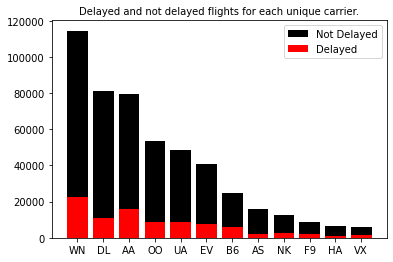

In [9]:
# Here's the graph
plt.title("Delayed and not delayed flights for each unique carrier.", size=10)
for x in sorted(elements, key=lambda tup: tup[1], reverse=True):
    plt.bar(x[0], x[1], color='black')
    plt.bar(x[0], x[2], color='red')
plt.legend(['Not Delayed', 'Delayed'])
plt.show()

In [10]:
# Extracting categorical features for One Hot Encoding
categorical = df[['UNIQUE_CARRIER', 'ORIGIN', 'DEST']]

In [11]:
# Fitting the encoder
oh = OneHotEncoder(sparse=False)
encoded = oh.fit_transform(categorical)

In [12]:
# Converting to a dataframe
dfe = pd.DataFrame(encoded, columns = ['l' + str(x+1) for x in range(encoded.shape[1])])

In [13]:
# Reseting the indexes
dfe.index = df.index
# Combining the dataframes
dfc = pd.concat([df, dfe], axis=1)

In [14]:
# These afre label encoded so we can get rid of them
dfc.drop(['UNIQUE_CARRIER', 'ORIGIN', 'DEST'], axis=1, inplace=True)

In [ ]:
# I will also convert the date to a number so the model can understand it
dfc['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
dfc['FL_DATE'] = [x.toordinal() for x in dfc['FL_DATE']]

## Choice of metric
### The best course of action will be using a precision score to evaluate the models output. The precision score looks at how much of thepredictions are correct across the classes. So it is not taking into account only the number of correct predictions but it is also weighting by the amount of elements in every category predicted.

### It is also useful to make a confusion matrix to see the amount of misclassifications and where they are.

## Choice of model
### After trying countless models like Logistic Regression, Boosting classifiers, Deep Neural Networks and KNN classifiers, I have decided to opt for Random Forest Classifier. This model should do goo due to the tabular nature of the data and I believe that it's structure and ability to ignore noise in the data will be useful for this particular data challenge. If a carrier or time if the day is showing a trend of being late, then the random forest classsifier should do a good job of catching onto that.

In [16]:
# df2 = df.sample(20000)
X = dfc.drop(['ARR_DEL15'], axis=1)
y = dfc['ARR_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, train_size=0.1, random_state = 42)

In [29]:
# Let's gridsearch the best combination of arguments
# Parameter grid
params = {'random_state': [42],
          'oob_score': [True],
          'n_jobs': [-1],
          'max_depth': [None, 3, 6, 9, 12, 16],
          'criterion': ['gini', 'entropy'],
          'class_weight': ['balanced', 'balanced_subsample']
         }

# Gridsearch
g = GridSearchCV(estimator = RandomForestClassifier(),
                 param_grid=params,
                 cv = 10)

In [30]:
# Here is GridSearchC
g.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 6, 9, 12, 16], 'n_jobs': [-1],
                         'oob_score': [True], 'random_state': [42]})

In [32]:
# Please do not run this as it will take ages, instead you can use the best parameters below.
p = g.predict(X_test)

In [33]:
# Makeing the confusion matrix
m = confusion_matrix(y_test, p)

In [38]:
accuracy_score(y_test,p)

0.8138501795168259

In [40]:
precision_score(y_test, p)

0.3657008613938919

In [39]:
# Here are the best parameters to run the model on your end
g.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42}

<BarContainer object of 1 artists>

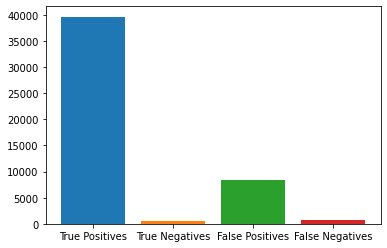

In [37]:
# Here's a plot of the model's decisions
plt.bar("True Positives", m[0][0])
plt.bar("True Negatives", m[1][1])

plt.bar("False Positives", m[1][0])
plt.bar("False Negatives", m[0][1])


### The model is favoring to predict no delays. Though this is not ideal, in this case if an airline is using this then I believe the model can be useful. It is better to announce to passengers that the flight will be on time sinze we do not want them to show up late for the flight and miss it.